# <font color='brown'>Setup </font>

In [1]:
%%time
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm
from matplotlib import pyplot as plt
from matplotlib import lines
import matplotlib.lines as mlines
import seaborn as sns

Wall time: 4.93 s


In [2]:
def fix_current_folder():
    folder = os.getcwd().split("\\")[-1]
    if folder == "Classification_datascience":
        os.chdir("webscrapping")
        print("Path updated!")

# <font color='brown'>Dataframe </font>

In [9]:
match = 37813
series = 17710

In [10]:
fix_current_folder()
from typing import List
from match_analysis import RoundReplay, generate_prediction_model, download_missing_matches, train_model

In [11]:
%%time
download_missing_matches(match, series)
model = train_model()

match → 37813 series → 17710
CSV downloaded at matches\exports\37814.csv
CSV downloaded at matches\exports\37813.csv
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Wall time: 2.59 s


In [12]:
analysis_df = pd.read_csv('matches\\exports\\{}.csv'.format(match), index_col=False)
rr = RoundReplay(match, analysis_df, model)

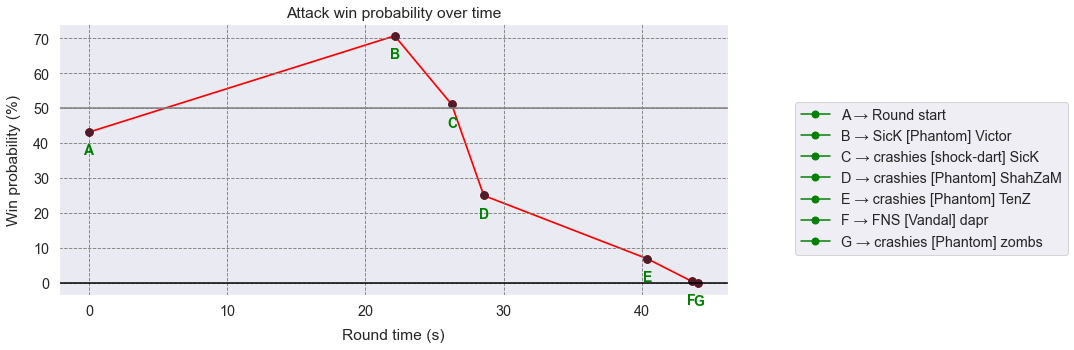

Wall time: 650 ms


In [13]:
%%time
rr.choose_round(28)

rr.plot_round(side="atk", marker_margin=0.5)

In [14]:
rr.get_map_impact_dataframe()

,Name,Gain,Lost,Delta
0,crashies,568.59,268.59,300.00
1,TenZ,360.30,287.91,72.39
2,yay,374.93,350.61,24.32
3,Marved,293.28,272.89,20.39
4,FNS,332.20,322.83,9.37
5,zombs,293.18,302.37,-9.19
6,dapr,302.96,337.39,-34.43
7,ShahZaM,316.10,396.77,-80.67
8,SicK,276.84,416.27,-139.43
9,Victor,248.63,411.38,-162.75


In [11]:
plt.figure(figsize=(12, 5))
color_dict = {"atk": "red", "def": "blue"}
marker_dict = {"atk": "#511C29", "def": "darkblue"}
round_data = rr.get_round_probability(side=chosen_side)

sns.set_context(rc={'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.lineplot(x="Round time", y="Win_probability", data=round_data,
  linewidth=0, zorder=0, color=color_dict[chosen_side])
ax.set(xlabel='Round time (s)', ylabel='Win probability (%)')
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.grid(linewidth=.4, color='gray', zorder=0)
title_dict = {"atk": "Attack", "def": "Defense"}
plt.title("{} win probability over time".format(title_dict[chosen_side]))
ax.lines[0].set_marker("o")
ax.lines[0].set_markersize(9)
plt.axhline(y=0, color="black")
plt.axhline(y=50, linestyle="-", color="grey", linewidth=1.5)
plt.grid(True, which='both', linestyle='--', zorder=0, linewidth=0.9)

x_data = list(round_data["Round time"])
y_data = list(round_data["Win_probability"])
marker_colors = [marker_dict[chosen_side]] * len(x_data)

def annotation(content: str, x_coord: float, y_coord: float, orientation: str):
    font_size = 14
    down_table = {"atk": -7, "def": -5}
    down_orientation = down_table[chosen_side]
    if orientation == "up":
        plt.gca().annotate(content, xy=(18, 61), xytext=(x_coord - 0.5, y_coord + 2.95), fontsize=font_size,
           color='green', weight='bold')
    elif orientation == "down":
        plt.gca().annotate(content, xy=(18, 61), xytext=(x_coord - 0.35, y_coord + down_orientation),
           fontsize=font_size, color='green', weight='bold')

prob_table = rr.get_round_probability(side=chosen_side)[["Round time", "Win_probability"]]
for index, item in enumerate(prob_table.iterrows()):
    fixed_index = index + 1
    aux = list(item[1])
    annotation(rr.letterify(fixed_index), aux[0], aux[1], "down")

plt.plot(x_data, y_data, linestyle="-", linewidth=1.7, color=color_dict[chosen_side], zorder=0)
for point in zip(x_data, y_data, marker_colors):
    plt.scatter(point[0], point[1], color=point[2], s=60)

plant = rr.get_plant_stamp(round_number)
if plant is not None:
    plt.axvline(x=plant)

locs = ["upper left", "lower left", "center right"]
blue_line = mlines.Line2D([], [], color='green', marker='o',
                          markersize=7, label='Blue stars')
label_list = [key + " → " + value for key, value in rr.get_round_story().items()]
plt.gca().legend(
    labels=label_list,
    handles=[blue_line]*len(label_list),
    loc=(1.1, 0.15))

plt.show()

# annotation(20, 39.70, "down")

NameError: name 'chosen_side' is not defined

<Figure size 864x360 with 0 Axes>

In [ ]:
rr.get_round_story()
qw = [key + " → " + value for key, value in rr.get_round_story().items()]
qw

In [ ]:
for i in prob_table.iterrows():
    print(list(i[1]))

In [ ]:
rr.get_round_probability(15, side="atk")

In [ ]:
rr.get_clutchy_rounds("atk")

In [ ]:
rr.get_round_dataframe(7)

In [ ]:
r_number = pd.Series(rr.get_round_table().keys())
r_atk = pd.Series(rr.get_atk_scores())
r_def = pd.Series(rr.get_def_scores())
r_winner = pd.Series([rr.get_match_winner()] * len(r_number))
r_ids = pd.Series([rr.match_id] * len(r_number))

frame = {'MatchID': r_ids, 'RoundNumber': r_number, 'AtkScore': r_atk, 'DefScore': r_def, 'FinalWinner': r_winner}

match_frame = pd.DataFrame(frame)

In [ ]:
match_frame

https://runitback.gg/series/12745?match=25645&round=19&tab=replay

# Match

In [ ]:
match = 26508
path2 = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\combined_csv.csv'
data = pd.read_csv('{}'.format(path2))

In [ ]:
class MatchReplay:
    def __init__(self, match_id: int, input_df: pd.DataFrame):
        self.df: pd.DataFrame = input_df
        self.match_id: int = match_id
        self.query: pd.DataFrame = input_df.query('MatchID == {}'.format(match_id))

    def get_round_table(self) -> dict:
        g = self.query[["RoundNumber", "RoundID"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.RoundID))

    def get_atk_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        atk_scores = []

        for i in dfm[:12]:
            if i == 1:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])
        for j in dfm[12:24]:
            if j == 0:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])

        return atk_scores

    def get_round_winners(self) -> dict:
        g = self.query[["RoundNumber", "FinalWinner"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.FinalWinner))

    def get_def_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        def_scores = []

        for i in dfm[:12]:
            if i == 0:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])
        for j in dfm[12:24]:
            if j == 1:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])

        return def_scores

    def get_match_winner(self) -> int:
        atks = self.get_atk_scores()
        defs = self.get_def_scores()

        winner = 0
        if atks[-1] == 12 and defs[-1] == 12:
            winner = 2
        elif atks[-1] == 13:
            winner = 1
        elif defs[-1] == 13:
            winner = 0
        return winner

    def generate_match_dataframe(self) -> pd.DataFrame:
        r_number = pd.Series(self.get_round_table().keys())
        r_atk = pd.Series(self.get_atk_scores())
        r_def = pd.Series(self.get_def_scores())
        r_winner = pd.Series([self.get_match_winner()] * len(r_number))
        r_ids = pd.Series([self.match_id] * len(r_number))

        frame = {'MatchID': r_ids, 'RoundNumber': r_number, 'AtkScore': r_atk, 'DefScore': r_def,
                 'FinalWinner': r_winner}

        d_frame = pd.DataFrame(frame)
        d_frame.dropna()

        return d_frame

    def get_all_matches(self) -> set:
        return set(self.df.MatchID)
    
    def get_atk_bank(self):
        return [
            max(self.query.query('RoundNumber == {}'.format(r)).ATK_bank)
            for r in self.get_round_table().keys()
        ]

    def get_big_dataframe(self):
        df_list = []
        match_indexes = list(self.get_all_matches())

        for i in match_indexes:
            self.match_id = i
            self.query: pd.DataFrame = self.df.query('MatchID == {}'.format(i))
            df_list.append(self.generate_match_dataframe())

        merged = pd.concat(df_list)
        merged.dropna(inplace=True)
        merged["AtkScore"] = merged["AtkScore"].astype(int)
        merged["DefScore"] = merged["DefScore"].astype(int)

        return merged

    def export_big_dataframe(self):
        big_df = self.get_big_dataframe()
        big_df.to_csv(r'matches\rounds\matches_csv.csv', index=False)
        
mr = MatchReplay(match, data)

In [ ]:
%%time
qq = mr.get_big_dataframe()
qq

In [ ]:
mr.get_atk_bank()

In [ ]:
mr.generate_match_dataframe()